# Fraud Detection with SQL

### Imports

In [55]:
import mysql.connector
from mysql.connector import Error
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

## Importing the data from SQL

In [2]:
def create_server_connection(host_name, user_name, user_password, database):
    connection = None
    try:
        connection =  mysql.connector.connect(
        host = host_name,
        user = user_name,
        passwd = user_password,
        database = database
        )
        print("MySQL Database connection successful")
    except Error as err:
        print(f"Error: '{error}'")
    return connection

pw = "Meangirls123!"

db = "fraud_detection"

connection = create_server_connection("localhost", "root", pw, db)

MySQL Database connection successful


In [3]:
def read_query(connection, query):
    cursor = connection.cursor()
    result = None
    try:
        cursor.execute(query)
        result = cursor.fetchall()
        return result
    except Error as err:
        print(f"Error: '{err}'")

In [4]:
q1 = """
SELECT * FROM cc_holder
"""

results1 = read_query(connection,q1)

In [5]:
from_db1 = []

for result in results1:
    result = list(result)
    from_db1.append(result)
columns = ["cc_holder_id","first_name","last_name","gender","cc_num"]

holder_df = pd.DataFrame(from_db1, columns = columns)

In [6]:
display(holder_df)

,cc_holder_id,first_name,last_name,gender,cc_num
0,0,Jeff,Elliott,M,2.29E+15\r
1,1,Joanne,Williams,F,3.57E+15\r
2,2,Ashley,Lopez,F,3.60E+15\r
3,3,Brian,Williams,M,3.59E+15\r
4,4,Nathan,Massey,M,3.53E+15\r
...,...,...,...,...,...
555714,555714,Michael,Olson,M,3.06E+13\r
555715,555715,Jose,Vasquez,M,3.56E+15\r
555716,555716,Ann,Lawson,F,6.01E+15\r
555717,555717,Eric,Preston,M,4.08E+12\r


In [7]:
q2 = """
SELECT * FROM transaction
"""

results2 = read_query(connection,q2)

In [8]:
from_db2 = []

for result in results2:
    result = list(result)
    from_db2.append(result)
columns = ['id',"data","amount","is_fraud","merchant_id","cc_holder_id"]

transaction_df = pd.DataFrame(from_db2, columns = columns)

In [9]:
display(transaction_df)

,id,data,amount,is_fraud,merchant_id,cc_holder_id
0,0,6/21/2020 12:14,2.86,0,0,0
1,1,6/21/2020 12:14,29.84,0,1,1
2,2,6/21/2020 12:14,41.28,0,2,2
3,3,6/21/2020 12:15,60.05,0,3,3
4,4,6/21/2020 12:15,3.19,0,4,4
...,...,...,...,...,...,...
555714,555714,12/31/2020 23:59,43.77,0,555714,555714
555715,555715,12/31/2020 23:59,111.84,0,555715,555715
555716,555716,12/31/2020 23:59,86.88,0,555716,555716
555717,555717,12/31/2020 23:59,7.99,0,555717,555717


In [11]:
q3 = """
SELECT * FROM merchant
"""

results3 = read_query(connection,q3)

from_db3 = []

for result in results3:
    result = list(result)
    from_db3.append(result)
columns = ['merchant_id',"merchant_name","merchant_category"]

merchant_df = pd.DataFrame(from_db3, columns = columns)

In [12]:
display(merchant_df)

,merchant_id,merchant_name,merchant_category
0,0,fraud_Kirlin and Sons,personal_care\r
1,1,fraud_Sporer-Keebler,personal_care\r
2,2,fraud_Swaniawski Nitzsche and Welch,health_fitness\r
3,3,fraud_Haley Group,misc_pos\r
4,4,fraud_Johnston-Casper,travel\r
...,...,...,...
555714,555714,fraud_Reilly and Sons,health_fitness\r
555715,555715,fraud_Hoppe-Parisian,kids_pets\r
555716,555716,fraud_Rau-Robel,kids_pets\r
555717,555717,fraud_Breitenberg LLC,travel\r


## Predictive Model

### Making one Dataframe

In [41]:
fraud_df = pd.concat([transaction_df,holder_df,merchant_df],axis = 1)

In [42]:
display(fraud_df)

,id,data,amount,is_fraud,merchant_id,cc_holder_id,cc_holder_id,first_name,last_name,gender,cc_num,merchant_id,merchant_name,merchant_category
0,0,6/21/2020 12:14,2.86,0,0,0,0,Jeff,Elliott,M,2.29E+15\r,0,fraud_Kirlin and Sons,personal_care\r
1,1,6/21/2020 12:14,29.84,0,1,1,1,Joanne,Williams,F,3.57E+15\r,1,fraud_Sporer-Keebler,personal_care\r
2,2,6/21/2020 12:14,41.28,0,2,2,2,Ashley,Lopez,F,3.60E+15\r,2,fraud_Swaniawski Nitzsche and Welch,health_fitness\r
3,3,6/21/2020 12:15,60.05,0,3,3,3,Brian,Williams,M,3.59E+15\r,3,fraud_Haley Group,misc_pos\r
4,4,6/21/2020 12:15,3.19,0,4,4,4,Nathan,Massey,M,3.53E+15\r,4,fraud_Johnston-Casper,travel\r
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555714,555714,12/31/2020 23:59,43.77,0,555714,555714,555714,Michael,Olson,M,3.06E+13\r,555714,fraud_Reilly and Sons,health_fitness\r
555715,555715,12/31/2020 23:59,111.84,0,555715,555715,555715,Jose,Vasquez,M,3.56E+15\r,555715,fraud_Hoppe-Parisian,kids_pets\r
555716,555716,12/31/2020 23:59,86.88,0,555716,555716,555716,Ann,Lawson,F,6.01E+15\r,555716,fraud_Rau-Robel,kids_pets\r
555717,555717,12/31/2020 23:59,7.99,0,555717,555717,555717,Eric,Preston,M,4.08E+12\r,555717,fraud_Breitenberg LLC,travel\r


In [43]:
fraud_df.drop(['merchant_id','cc_holder_id','cc_holder_id',], axis = 1, inplace = True)

### Label encoding the features

In [44]:
features = ["amount","merchant_category","gender","cc_num"]
target = "is_fraud"

In [45]:
number = LabelEncoder()

for feature in features:
    if not feature == 'amount':
        fraud_df[feature] = number.fit_transform(fraud_df[feature])

In [46]:
fraud_df.head(5)

,id,data,amount,is_fraud,first_name,last_name,gender,cc_num,merchant_name,merchant_category
0,0,6/21/2020 12:14,2.86,0,Jeff,Elliott,1,9,fraud_Kirlin and Sons,10
1,1,6/21/2020 12:14,29.84,0,Joanne,Williams,0,50,fraud_Sporer-Keebler,10
2,2,6/21/2020 12:14,41.28,0,Ashley,Lopez,0,53,fraud_Swaniawski Nitzsche and Welch,5
3,3,6/21/2020 12:15,60.05,0,Brian,Williams,1,52,fraud_Haley Group,9
4,4,6/21/2020 12:15,3.19,0,Nathan,Massey,1,46,fraud_Johnston-Casper,13


### Implementing the Decision Tree Classifier

In [48]:
X_train, X_val, y_train, y_val = train_test_split(fraud_df[features],
                                                  fraud_df[target],
                                                  test_size = .20,
                                                    random_state = 50
                                                 )

In [51]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

train_predictions = model.predict(X_train)
train_accuracy = accuracy_score(y_train, train_predictions)

val_predictions = model.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)

print(f"Training Accuracy: {train_accuracy}")
print(f"Validation Accuracy: {val_accuracy}")

Training Accuracy: 0.9999820052859473
Validation Accuracy: 0.996293097243216


<function matplotlib.pyplot.show(close=None, block=None)>

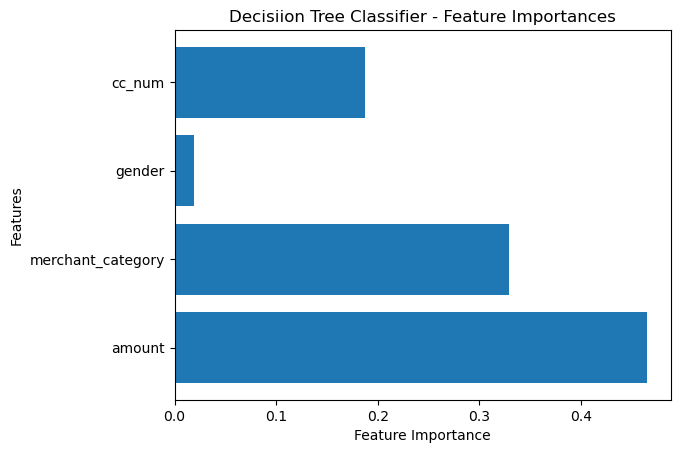

In [57]:
feature_importances = model.feature_importances_

plt.barh(features, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Decisiion Tree Classifier - Feature Importances')
plt.show


## Summary

### SQL

In SQL, a database was created to hold credit card transactions. There are 3 tables: credit card holder, merchant, and the transaction. Each of the table has its own primary key, and the transaction table has two foreign keys which links it to the other two tables. Next, the data was loaded into SQL from different csv files which were cleaned in Excel from a Kaggle dataset which is linked below.

### Data Set

https://www.kaggle.com/datasets/kartik2112/fraud-detection

The data set was made through a simulation which was made by Brandon Harris

## Predictive Model

Based off research on fraud detection models, I decided to use a decision tree classifier. The features that were used were the amount of the transaction, the merchant category, gender of the person and the beginning number of the credit card. Every feature was label encoded besides the amount which was a float. Based on the feature importances, the amount of the transaction was the most important in predicting whether a transaction was fraudulent or not.